# Exercise for Chapter 5 (Solutions)

In [93]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

register_matplotlib_converters()


plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

import warnings
warnings.filterwarnings('ignore')


In [94]:
pd.options.display.max_columns = None
pd.options.display.width=None
sns.set(style="darkgrid")

### Exercise 1

__Technical Rules__: Consider the data on exchange rates (in file, exchange_rates_1.csv) between the Indian Rupee and the US Dollar, British Pound and Euro. It is daily data from December 4, 2006 to November 5, 2010. 
In order to compare the performance of a strategy, appropriately normalize the entry point exchange rate: Invest equal amounts of capital (counted in INR, which we will call the “base currency”) in each trade. Total portfolio return on each day should be computed as a weighted sum of returns from each active trade (weighted by the current value of each trade). 
Evaluate the signals discussed below using the Sharpe ratios and PNL with and without transaction costs of 15 basis points. Assume a risk free rate of 3%. (1 basis point = 10−4; so each dollar traded costs 0.0015 in transaction costs).

1. __Moving Average Trading Rules__: Trading signals are generated from the relative levels of the price series and a moving average of past prices.
- Rule 1: Let $\bar{p_{t}}^{(m)}$ as defined in (5.6); use the strategy to sell if $ p_{t} > \bar{p_{t}}^{(m)}$ and to buy if $ p_{t} < \bar{p_{t}}^{(m)}$. Evaluate this strategy. What is the optimal $m$?

- Rule 2 (Bollinger Rule): Use the Bollinger rule as outlined in the text; what is the optimal $m$?

- Rule 3 (Resistance-Support): Buy if $p_{t} > max_{0 \leq i<m} p_{t-1}$ and sell if $p_{t} < min_{0 \leq i<m} p_{t-1}$. Evaluate this rule. What is the optimal $m$?

- Rule 4 (Momentum): Compute a short-term moving average over the last $m$ prices, $\bar{p_{t}}^{(m)}$ and a long-term average over the last  $n$ prices, $\bar{p_{t}}^{(n)}$ with $m < n$. If $\bar{p_{t}}^{(m)}$ crosses $\bar{p_{t}}^{(n)}$ from below, sell and if it crosses $\bar{p_{t}}^{(n)} $ from above, buy. Evaluate this strategy. What are the optimal values of $m$ and $n$?

2. __RSI Oscillator Rule__: Use $\text{RSI}_{t}$ as defined in Section 5.3. If $\text{RSI}_{t}$  < 30, buy and if $\text{RSI}_{t}$  > 70, sell. Evaluate this trading strategy. What is the optimal '$m$'?

3. __Pairs Trading - Distance Method__: We want to develop a pairs trading strategy and check if it does any better than the strategies in (1) and (2). At the last trading day of the month, look back 3 months and identify if any pairs are worth trading. Use the distance measures, thresholds, as given in the text. (See Section 5.8.1).

4. __Pairs Trading - Co-Integration Method (Section 5.8.2)__:
In the co-integration method, we can consider the possibility of trading more than 2 assets. Check using a moving window of three months which series are cointegrated. Develop appropriate trading strategies to trade portfolios formed from the co-integrating vectors and compare with the pairs trading strategies based on other criteria. Concretely define the trading indicators and thresholds for entry
and exit. Summarize the performance results.

5. __Pairs Trading - APT Method__:
Consider the data with the S&P 500 market index returns and assume that the risk free rate is $3\%$. Regress each currency’s excess return (over the risk free rate) on the excess market return over a moving window of 3 months. Find pairs based on the similarity of the regression coefficients.
_ Compare the pairs that result from the APT method with those obtained in Problem 2.
_ After finding the pairs, use the same rules as in Exercise 2 to decide when to enter and exit specific trades. Summarize the performance results.

6. __Summing Up__
Provide a summary table of portfolio returns of all methods with the main findings and drawbacks of all the methods that are explored in this exercise. In particular,comment on the performance of single-asset strategies versus multi-asset strategies. Also comment on whether the market factor adds any value.

In [95]:
fx_prices = pd.read_csv('../datasets/exchange_rates_1.csv',index_col='Date',parse_dates=['Date'])
fx_prices.columns = ['USDINR','GBPINR','EURINR']
fx_prices.round(2).head()

,USDINR,GBPINR,EURINR
Date,,,
2006-12-04,44.59,88.24,59.40
2006-12-05,45.10,89.27,60.17
2006-12-06,44.69,87.95,59.38
2006-12-07,44.66,87.94,59.44
2006-12-08,44.66,87.60,59.34


To evaluate all these strateies we need to build a simple but complete backtesting tool. Let's incrementally build together a vectorized backtester with the right charateristics and we'll then generalize it to test all the other strategies.

We estimate the signal as something that when positive we'll go long and when negative we'll go short and if it's exactly 0 we take no action. In the first example we use a rolling average (pick 100 lags to start) and compare it with the price

In [230]:
mav = fx_prices.rolling(100).mean()
signal = fx_prices - mav
signal.dropna().head()

,USDINR,GBPINR,EURINR
Date,,,
2007-04-27,-2.692590,-3.738601,-1.708698
2007-04-30,-2.749289,-4.142731,-1.955640
2007-05-02,-2.707755,-4.097084,-1.980615
2007-05-03,-2.798885,-4.225123,-2.017206
2007-05-04,-2.981196,-4.908451,-2.489508


The position is set as the sign of the signal

In [231]:
pos = signal.apply(np.sign)
pos.dropna().head()

,USDINR,GBPINR,EURINR
Date,,,
2007-04-27,-1.0,-1.0,-1.0
2007-04-30,-1.0,-1.0,-1.0
2007-05-02,-1.0,-1.0,-1.0
2007-05-03,-1.0,-1.0,-1.0
2007-05-04,-1.0,-1.0,-1.0


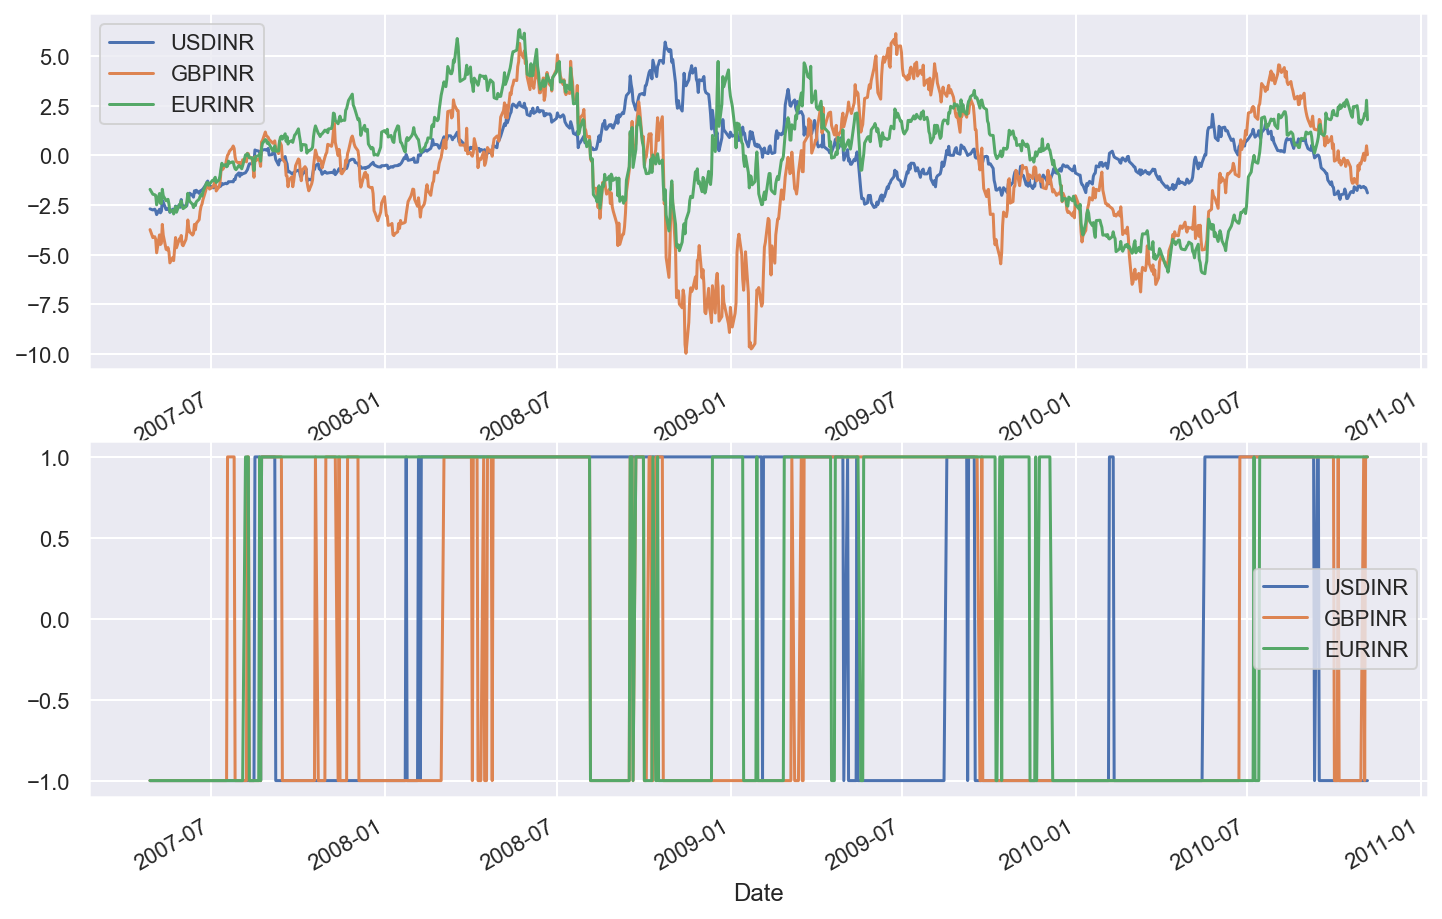

In [232]:
fig,ax = plt.subplots(2,1,figsize=(12,8))
_ = signal.plot(ax=ax[0])
pos.plot(ax=ax[1])
plt.show()

The return of the strategy is the return of the instrument times the position. We shift the position by 1 to avoid lookahead bias. We use log returns

In [ ]:
ret = fx_prices.apply(np.log).diff(1).fillna(0)
strat_ret = pos.shift(1)*ret

The strategy perfromance is evaluated by suming the log returns en exponecing the result. If you want to see the strategy return incrementally we do a cumsum

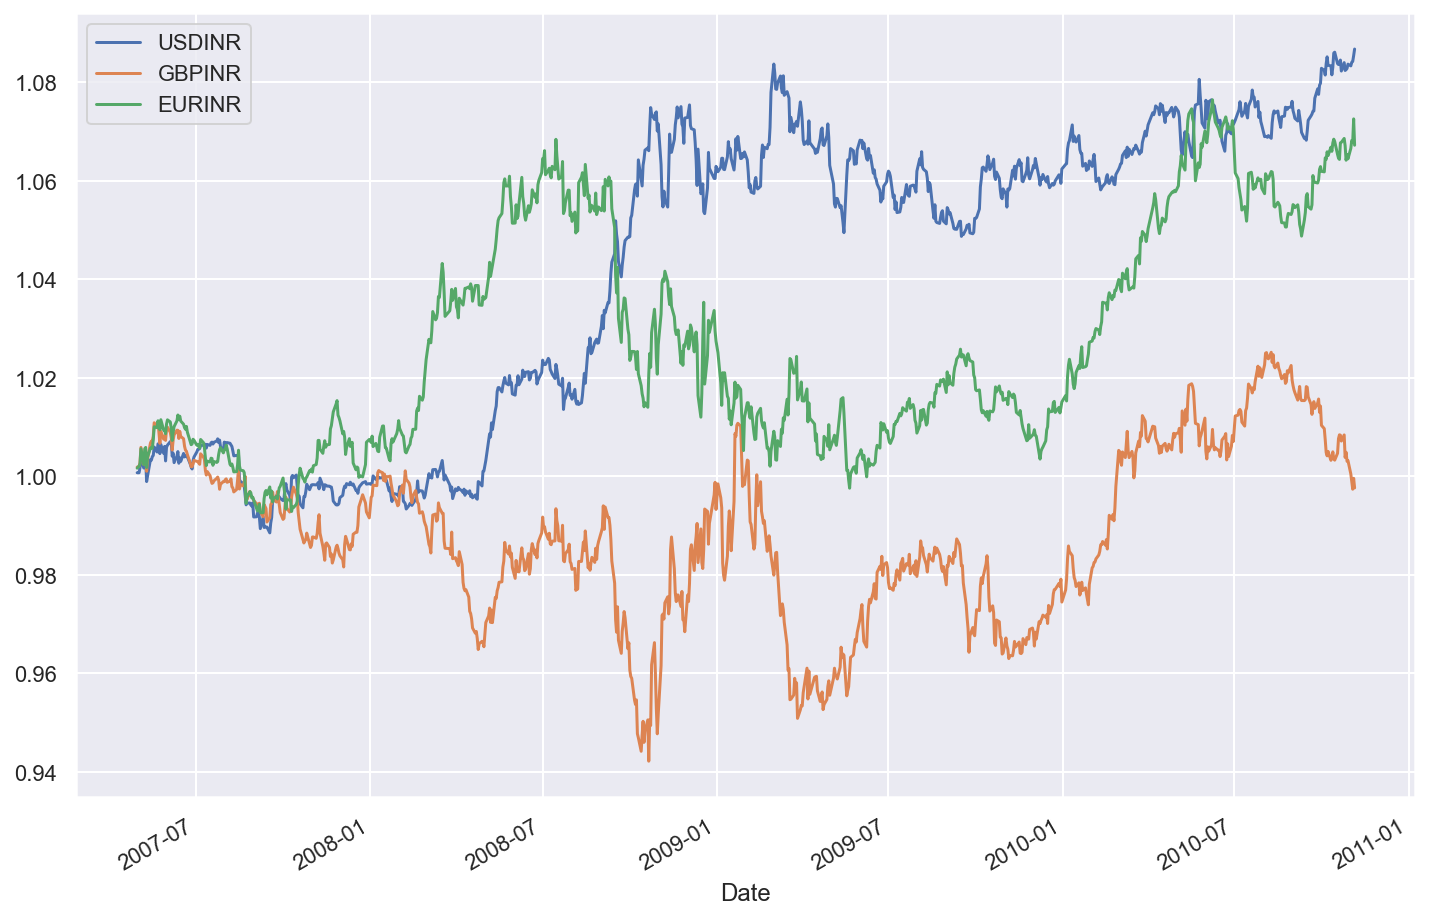

In [143]:
fig,ax = plt.subplots(figsize=(12,8))
_ = strat_ret.cumsum().apply(np.exp).plot(ax=ax)
plt.show()

To look at the portfolio return where we allocate 1 unit per instrument we need to renormalize the position and then sum the individual returns


In [145]:
pos /= pos.abs().sum(axis=1).values.reshape(-1,1)
port_return = (pos.shift(1)*ret).sum(axis=1)

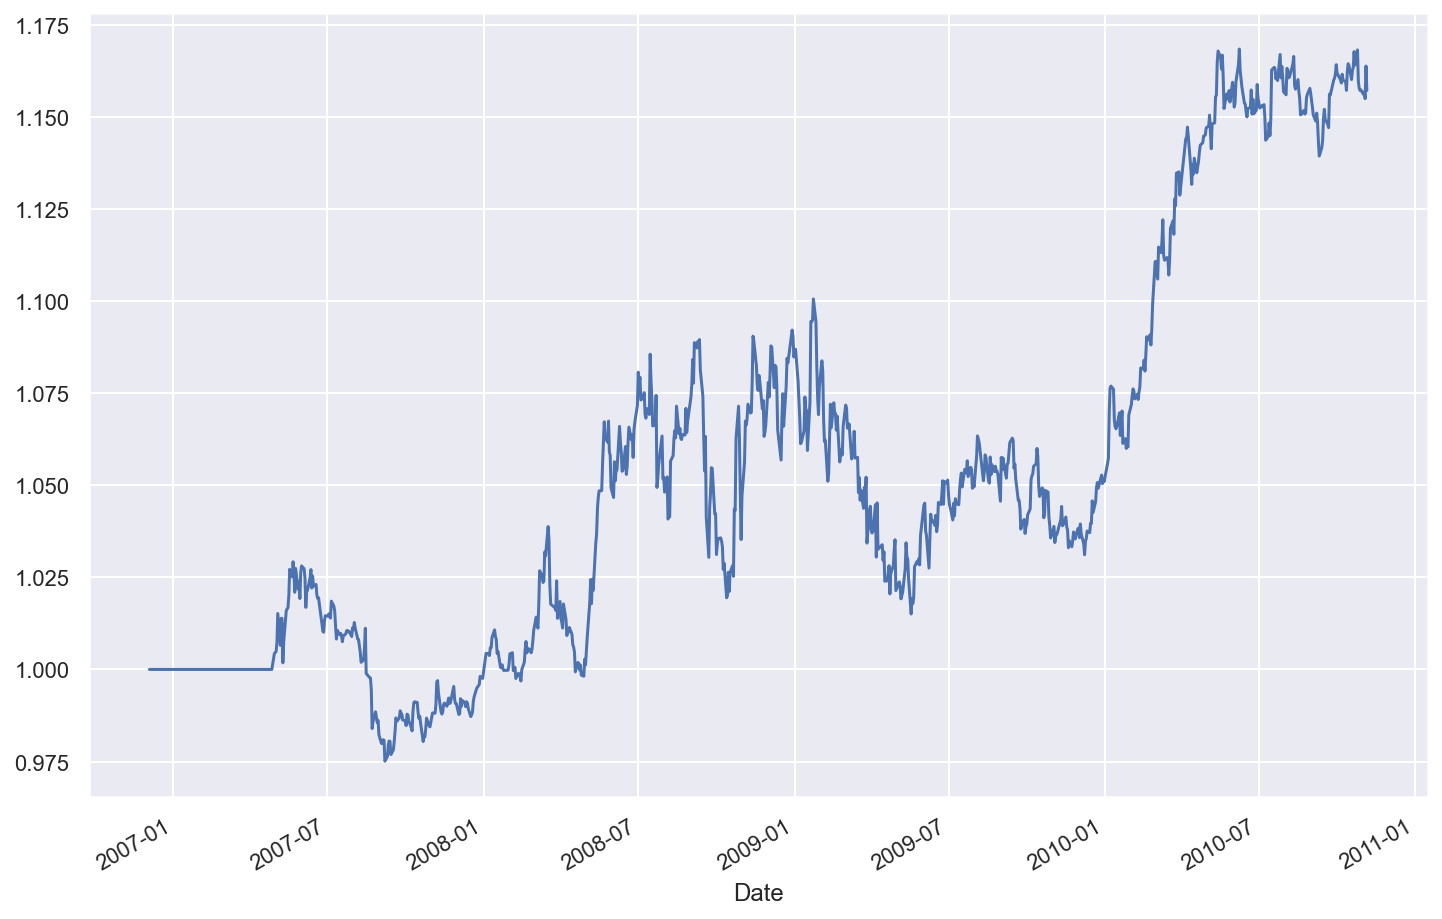

In [146]:
fig,ax = plt.subplots(figsize=(12,8))
_ = port_return.cumsum().apply(np.exp).plot(ax=ax)
plt.show()

finally we estimate the annualized returns and Sharpe Ratio

In [148]:
annualized_risk_free_ret = 0.03
annualized_ret = port_return.mean()*250
annualized_sd = port_return.std()*np.sqrt(250)

sr = (annualized_ret-annualized_risk_free_ret)/annualized_sd
print(f'Ret: {annualized_ret}, STD: {annualized_sd} -> SR: {sr}')

Ret: 0.03641750480328093, STD: 0.07012909273938266 -> SR: 0.09150987917567954


If we need to add Transaction costs we need an extra step: Calculate the trades (just diff the position) and add an additional costs to the returns

In [154]:
tc_pct = 15/10000 # 15bps
delta_pos = pos.diff(axis=1).abs().sum(axis=1)
tcs = tc_pct*delta_pos
port_return_tcs = (pos.shift(1)*ret).sum(axis=1) - tcs

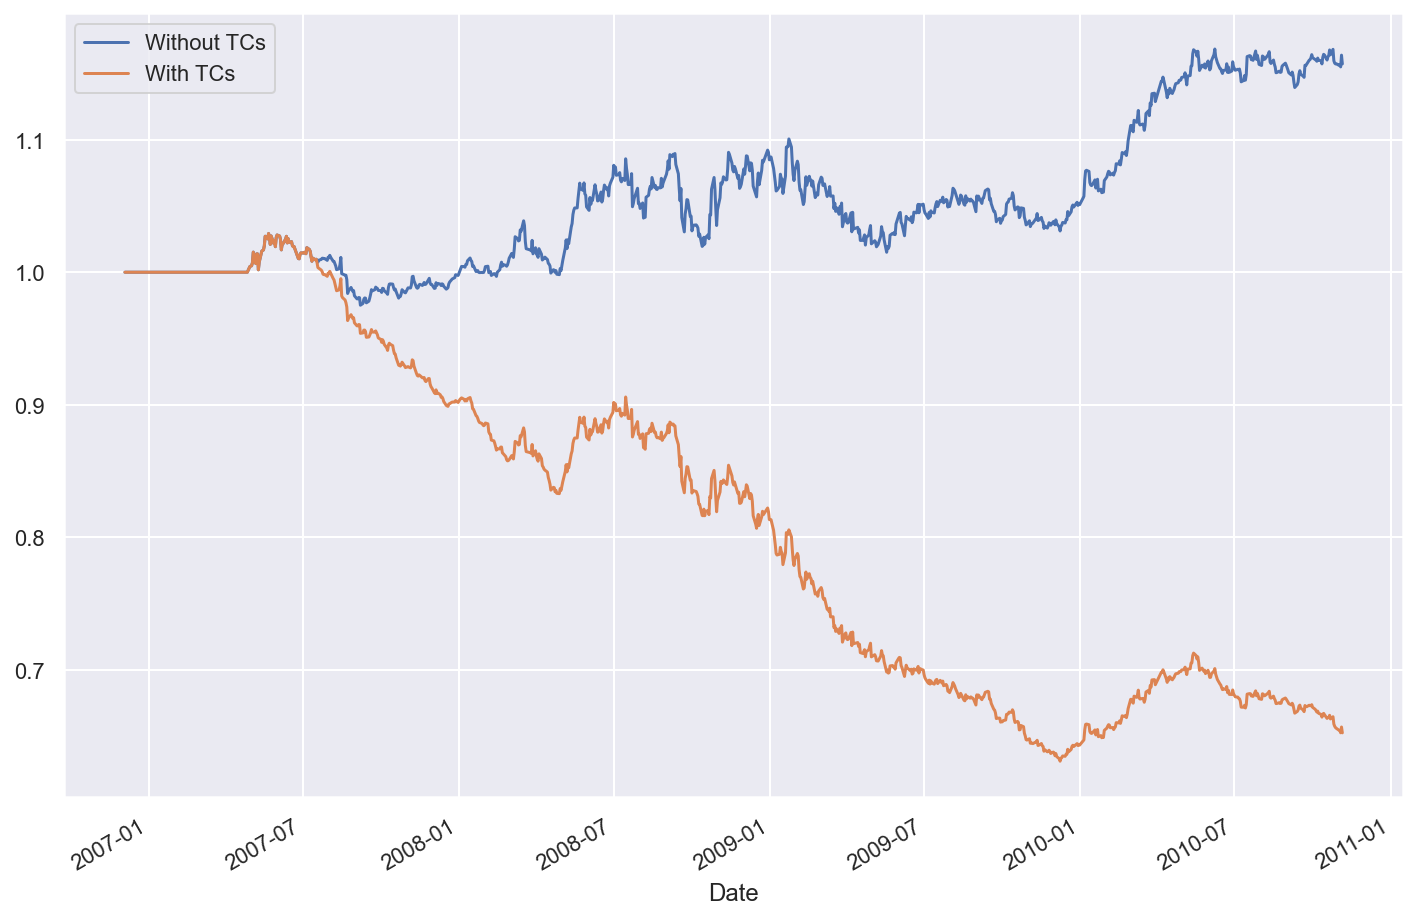

In [157]:
fig,ax = plt.subplots(figsize=(12,8))
_ = port_return.cumsum().apply(np.exp).plot(ax=ax)
_ = port_return_tcs.cumsum().apply(np.exp).plot(ax=ax)
plt.legend(['Without TCs','With TCs'])
plt.show()

In [156]:
annualized_risk_free_ret = 0.03
annualized_ret = port_return_tcs.mean()*250
annualized_sd = port_return_tcs.std()*np.sqrt(250)

sr = (annualized_ret-annualized_risk_free_ret)/annualized_sd
print(f'Ret: {annualized_ret}, STD: {annualized_sd} -> SR: {sr}')

Ret: -0.10654656705300651, STD: 0.07125436540741895 -> SR: -1.9163256352401585


Now that we know what we need to do let's just write a function that allows the backtesting of a strategy based on a function that generates a particular signal. The strategy will support parameters

In [206]:
def backtest_strategy(fx_prices,strategy,strategy_params,rf_rate=0.03,tc_pct=None):
    signal = strategy(fx_prices,strategy_params)
    pos = signal.apply(np.sign)
    
    pos /= pos.abs().sum(axis=1).values.reshape(-1,1)
    
    ret = fx_prices.apply(np.log).diff(1).fillna(0)
    
    port_return = (pos.shift(1)*ret).sum(axis=1)
    
    if tc_pct:
        delta_pos = pos.diff(axis=1).abs().sum(axis=1)
        tcs = tc_pct*delta_pos
        port_return -= tcs
    
    annualized_ret = port_return.mean()*250
    annualized_sd = port_return.std()*np.sqrt(250)
    sr = (annualized_ret-annualized_risk_free_ret)/annualized_sd

    return (annualized_ret,sr)

Let's test it with the simple mav strategy to ensure we get the same results.

In [233]:
def mav_strategy(prices,params):
    mav = prices.rolling(params.get('m')).mean()
    signal = prices - mav
    return signal

In [234]:
params = dict(m=100)

In [235]:
res = backtest_strategy(fx_prices,mav_strategy,params)
res

(0.03641750480328093, 0.09150987917567954)

In [236]:
res_tcs = backtest_strategy(fx_prices,mav_strategy,params,tc_pct=15/10000)
res_tcs

(-0.10654656705300651, -1.9163256352401585)

We are finally ready to go.

#### Part 1

##### Rule 1

We use the strategy we already wrote and we test it on a range of $m$s: from 20 to 300 with 1 increment

In [237]:
m_values = list(range(20,310,10))

In [238]:
results = []

for m in m_values:
    params = dict(m=m)
    ret,sr = backtest_strategy(fx_prices,mav_strategy,params)
    results.append(dict(m=m,SR=sr,Ret=ret))

results = pd.DataFrame(results).set_index('m')
results

,SR,Ret
m,,
20,-0.146717,0.019267
30,-0.334795,0.005506
40,-0.214135,0.014145
50,-0.380077,0.001865
60,-0.422620,-0.001663
70,-0.272981,0.009447
80,-0.008687,0.029367
90,0.193524,0.043978
100,0.091510,0.036418


We see that the current optimal $m$ is 90 days with a return of 4.35% and a SR of 0.2.

However if we include transactions costs get get a different story:

In [239]:
results = []

for m in m_values:
    params = dict(m=m)
    ret,sr = backtest_strategy(fx_prices,mav_strategy,params,tc_pct=15/10000)
    results.append(dict(m=m,SR=sr,Ret=ret))

results = pd.DataFrame(results).set_index('m')
results

,SR,Ret
m,,
20,-2.474777,-0.156631
30,-2.472776,-0.155921
40,-2.157631,-0.133809
50,-2.261662,-0.140849
60,-2.149243,-0.135395
70,-1.900210,-0.116801
80,-1.755693,-0.100623
90,-1.685587,-0.093747
100,-1.916326,-0.106547


In this case the return is always negative with 90 days still the best case.

##### Rule 2

In [ ]:
def bollinger_strategy(prices,params):
    mav = fx_prices.rolling(params.get('m')).mean()
    mstd = fx_prices.rolling(params.get('m')).std()
    p_plus = mav + 2*mstd
    p_minus=
    signal = fx_prices - (mav + 2*mstd)
    return signal

In [240]:
mav = fx_prices.rolling(params.get('m')).mean()
mstd = fx_prices.rolling(params.get('m')).std()

In [303]:
p_plus =  mav + 2*mstd
p_minus = mav -2*mstd

In [251]:
signal = np.where(fx_prices > p_plus,fx_prices - p_plus,0)

TypeError: where() got an unexpected keyword argument 'axis'

In [249]:
signal.dropna().head()

AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

In [255]:
(fx_prices - p_plus >0).dropna()

TypeError: no numeric data to plot

In [299]:
def test(df, p_plus,p_minus):
    
    p_p = p_plus.loc[:,df.name]
    p_m = p_minus.loc[:,df.name]
    signal = 0*df
    signal = signal.loc[df>p_p]= df-p_p
    signal = signal.loc[df<p_m]= p_m-df
    return signal

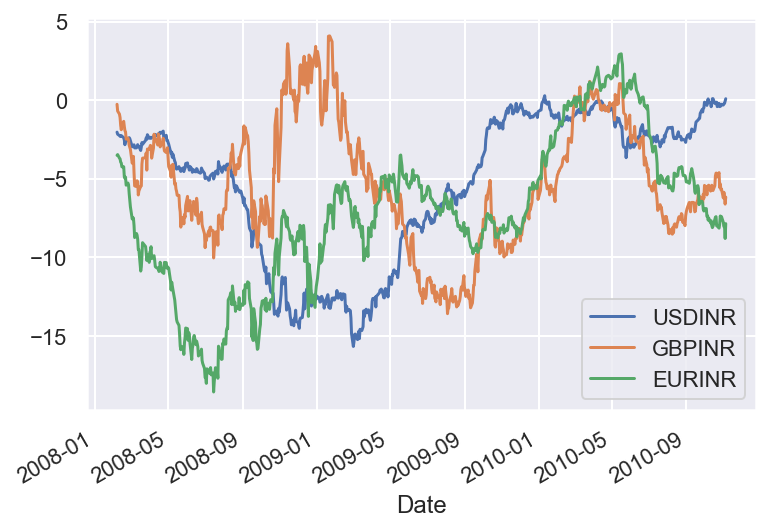

In [301]:
fx_prices.apply(test,p_plus = p_plus, p_minus=p_minus).plot()

In [305]:
a = (fx_prices-p_plus)

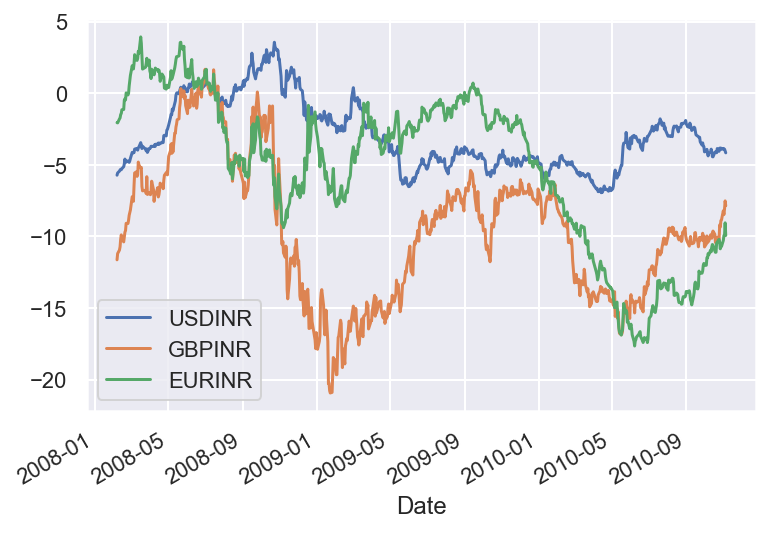

In [306]:
a.plot()

In [309]:
a.apply(lambda x: 0 if x<0 else x)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().